In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.cuda.empty_cache()
import matplotlib.pyplot as plt

from timeit import default_timer
from utilities3 import UnitGaussianNormalizer, count_params, LpLoss
from pytorch_wavelets import DTCWTForward, DTCWTInverse

torch.manual_seed(0)
np.random.seed(0)

print(f'available devices: {torch.cuda.device_count()}')
print(f'current device: { torch.cuda.current_device()}')
print(f'current device: { torch.cuda.get_device_name()}')

available devices: 2
current device: 0
current device: Quadro RTX 5000


In [2]:
device = 'cuda:0'

In [3]:
""" Def: 2d Wavelet layer """

class WaveConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, level, dummy):
        super(WaveConv2d, self).__init__()

        """
        2D Wavelet layer. It does DWT, linear transform, and Inverse dWT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.level = level
        self.dwt_ = DTCWTForward(J=self.level, biort='near_sym_b', qshift='qshift_b').to(dummy.device)
        self.mode_dwt, self.coef_dwt = self.dwt_(dummy) 
        self.modes1 = self.mode_dwt.shape[-2]
        self.modes2 = self.mode_dwt.shape[-1]
        self.modes3 = self.coef_dwt[-1].shape[-3]
        self.modes4 = self.coef_dwt[-1].shape[-2]

        self.scale = (1 / (in_channels * out_channels))
        self.weights0 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2))
        self.weights1a = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes3, self.modes4))
        self.weights1b = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes3, self.modes4))
        self.weights2a = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes3, self.modes4))
        self.weights2b = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes3, self.modes4))
        self.weights3a = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes3, self.modes4))
        self.weights3b = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes3, self.modes4))
        self.weights4a = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes3, self.modes4))
        self.weights4b = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes3, self.modes4))
        self.weights5a = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes3, self.modes4))
        self.weights5b = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes3, self.modes4))
        self.weights6a = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes3, self.modes4))
        self.weights6b = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes3, self.modes4))
        
        
    # Convolution
    def mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        # Compute single tree Discrete Wavelet coefficients using some wavelet
        dwt = DTCWTForward(J=self.level, biort='near_sym_b', qshift='qshift_b').to(x.device)
        x_ft, x_coeff = dwt(x)

        # Multiply relevant Wavelet modes
        out_ft = self.mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights0)
        # Multiply the finer wavelet coefficients
        x_coeff[-1][:,:,0,:,:,0] = self.mul2d(x_coeff[-1][:,:,0,:,:,0].clone(), self.weights1a)
        x_coeff[-1][:,:,0,:,:,1] = self.mul2d(x_coeff[-1][:,:,0,:,:,1].clone(), self.weights1b)
        x_coeff[-1][:,:,1,:,:,0] = self.mul2d(x_coeff[-1][:,:,1,:,:,0].clone(), self.weights2a)
        x_coeff[-1][:,:,1,:,:,1] = self.mul2d(x_coeff[-1][:,:,1,:,:,1].clone(), self.weights2b)
        x_coeff[-1][:,:,2,:,:,0] = self.mul2d(x_coeff[-1][:,:,2,:,:,0].clone(), self.weights3a)
        x_coeff[-1][:,:,2,:,:,1] = self.mul2d(x_coeff[-1][:,:,2,:,:,1].clone(), self.weights3b)
        x_coeff[-1][:,:,3,:,:,0] = self.mul2d(x_coeff[-1][:,:,3,:,:,0].clone(), self.weights4a)
        x_coeff[-1][:,:,3,:,:,1] = self.mul2d(x_coeff[-1][:,:,3,:,:,1].clone(), self.weights4b)
        x_coeff[-1][:,:,4,:,:,0] = self.mul2d(x_coeff[-1][:,:,4,:,:,0].clone(), self.weights5a)
        x_coeff[-1][:,:,4,:,:,1] = self.mul2d(x_coeff[-1][:,:,4,:,:,1].clone(), self.weights5b)
        x_coeff[-1][:,:,5,:,:,0] = self.mul2d(x_coeff[-1][:,:,5,:,:,0].clone(), self.weights6a)
        x_coeff[-1][:,:,5,:,:,1] = self.mul2d(x_coeff[-1][:,:,5,:,:,1].clone(), self.weights6b)
        
        # Return to physical space        
        idwt = DTCWTInverse(biort='near_sym_b', qshift='qshift_b').to(x.device)
        x = idwt((out_ft, x_coeff))
        
        return x

In [4]:
""" The forward operation """

class WNO2d(nn.Module):
    def __init__(self, width, level, dummy_data):
        super().__init__()

        """
        The WNO network. It contains 4 layers of the Wavelet integral layer.
        1. Lift the input using v(x) = self.fc0 .
        2. 4 layers of the integral operators v(+1) = g(K(.) + W)(v).
            W is defined by self.w_; K is defined by self.conv_.
        3. Project the output of last layer using self.fc1 and self.fc2.

        """

        self.level = level
        self.width = width
        self.dummy_data = dummy_data
        self.padding = 2 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(4, self.width) # input channel is 3: (a(x, y), x, y)

        self.conv0 = WaveConv2d(self.width, self.width, self.level, self.dummy_data)
        self.conv1 = WaveConv2d(self.width, self.width, self.level, self.dummy_data)
        self.conv2 = WaveConv2d(self.width, self.width, self.level, self.dummy_data)
        self.conv3 = WaveConv2d(self.width, self.width, self.level, self.dummy_data)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 64)
        self.fc2 = nn.Linear(64, 1)
        
    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)
        # x = F.pad(x, [0,self.padding, 0,self.padding]) # padding, if required
        
        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)
        
        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)
        
        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)
        
        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2
        
        # x = x[..., :-self.padding, :-self.padding] # removing padding, when applicable
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        
        return x
    
    def get_grid(self, shape, device):
        # The grid of the solution
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 690, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 690, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)

In [5]:
class WNO2d_NT(nn.Module):
    def __init__(self, width, level, dummy_data):
        super().__init__()

        """
        The WNO network. It contains 4 layers of the Wavelet integral layer.
        1. Lift the input using v(x) = self.fc0 .
        2. 4 layers of the integral operators v(+1) = g(K(.) + W)(v).
            W is defined by self.w_; K is defined by self.conv_.
        3. Project the output of last layer using self.fc1 and self.fc2.

        """

        self.level = level
        self.width = width
        self.dummy_data = dummy_data
        self.padding = 2 # pad the domain if input is non-periodic
        
        self.fc0_NT = nn.Linear(4, self.width).requires_grad_(False) # input channel is 3: (a(x, y), x, y)

        self.conv0_NT = WaveConv2d(self.width, self.width, self.level, self.dummy_data).requires_grad_(False)
        self.conv1_NT = WaveConv2d(self.width, self.width, self.level, self.dummy_data).requires_grad_(False)
        self.conv2_NT = WaveConv2d(self.width, self.width, self.level, self.dummy_data).requires_grad_(False)
        self.conv3_NT = WaveConv2d(self.width, self.width, self.level, self.dummy_data).requires_grad_(False)
        self.w0_NT = nn.Conv2d(self.width, self.width, 1).requires_grad_(False)
        self.w1_NT = nn.Conv2d(self.width, self.width, 1).requires_grad_(False)
        self.w2_NT = nn.Conv2d(self.width, self.width, 1).requires_grad_(False)
        self.w3_NT = nn.Conv2d(self.width, self.width, 1).requires_grad_(False)

        self.fc1_NT = nn.Linear(self.width, 64).requires_grad_(False)
        self.fc2_NT = nn.Linear(64, 1).requires_grad_(False)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        
        x_NT = self.fc0_NT(x)
        x_NT = x_NT.permute(0, 3, 1, 2)
        # x_NT = F.pad(x_NT, [0,self.padding,0,self.padding]) # do padding, if required
        
        x1_NT = self.conv0_NT(x_NT)
        x2_NT = self.w0_NT(x_NT)
        x_NT = x1_NT + x2_NT
        x_NT = F.gelu(x_NT)
        
        x1_NT = self.conv1_NT(x_NT)
        x2_NT = self.w1_NT(x_NT)
        x_NT = x1_NT + x2_NT
        x_NT = F.gelu(x_NT)
        
        x1_NT = self.conv2_NT(x_NT)
        x2_NT = self.w2_NT(x_NT)
        x_NT = x1_NT + x2_NT
        x_NT = F.gelu(x_NT)
        
        x1_NT = self.conv3_NT(x_NT)
        x2_NT = self.w3_NT(x_NT)
        x_NT = x1_NT + x2_NT
        
        # x_NT = x_NT[..., :-self.padding, :-self.padding] # remove padding, when required
        x_NT = x_NT.permute(0, 2, 3, 1)
        x_NT = self.fc1_NT(x_NT)
        x_NT = F.gelu(x_NT)
        x_NT = self.fc2_NT(x_NT)
        
        return x_NT
    
    def get_grid(self, shape, device):
        # The grid of the solution
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 690, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 690, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)

In [6]:
""" Model configurations """

ntrain = 500
ntest = 40

batch_size = 20
learning_rate = 0.001

epochs = 500
step_size = 50
gamma = 0.75

level = 4
width = 64

h = 70
s = h

In [7]:
import pickle

filename = './dataset_xtr_im.sav'
x_train = pickle.load(open(filename, 'rb'))

filename = './dataset_ytr_im.sav'
y_train = pickle.load(open(filename, 'rb'))

filename = './dataset_xte_im.sav'
x_test = pickle.load(open(filename, 'rb'))[0:ntest*5]

filename = './dataset_yte_im.sav'
y_test = pickle.load(open(filename, 'rb'))[0:ntest*5]

x_train.shape, y_train.shape, x_test.shape, y_test.shape

/home/souvik/anaconda3/envs/SG_pytorch/lib/python3.12/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


(torch.Size([2500, 70, 70, 2]),
 torch.Size([2500, 70, 70]),
 torch.Size([200, 70, 70, 2]),
 torch.Size([200, 70, 70]))

In [19]:
x_train[0,:,:,0], x_train[0,:,:,0].shape, x_train[0,:,:,1], x_train[0,:,:,1].shape

(tensor([[1709., 1709., 1709.,  ..., 4307., 4321., 4321.],
         [1709., 1709., 1709.,  ..., 4307., 4321., 4321.],
         [1709., 1709., 1709.,  ..., 4307., 4321., 4321.],
         ...,
         [1709., 1709., 1709.,  ..., 4307., 4321., 4321.],
         [1709., 1709., 1709.,  ..., 4307., 4321., 4321.],
         [1709., 1709., 1709.,  ..., 4307., 4321., 4321.]]),
 torch.Size([70, 70]),
 tensor([[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]),
 torch.Size([70, 70]))

In [8]:
from utilities3 import UnitGaussianNormalizer, count_params, LpLoss, MatReader

x_normalizer = UnitGaussianNormalizer(x_train)
x_train = x_normalizer.encode(x_train)
x_test = x_normalizer.encode(x_test)

y_normalizer = UnitGaussianNormalizer(y_train)
y_train = y_normalizer.encode(y_train)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train),
                                           batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test),
                                          batch_size=batch_size, shuffle=False)

In [9]:
model = WNO2d(width, level, x_train[0:1,:,:,:].permute(0,3,1,2)).to(device)
print(count_params(model))

from torchinfo import summary
print(summary(model, input_size=(batch_size, 70, 70, 2)))

model = WNO2d_NT(width, level, x_train[0:1,:,:,:].permute(0,3,1,2)).to(device)
print('\n\n\n\n\n')
print(count_params(model))

from torchinfo import summary
print(summary(model, input_size=(batch_size, 70, 70, 2)))

6574785
Layer (type:depth-idx)                   Output Shape              Param #
WNO2d                                    [20, 70, 70, 1]           --
├─Linear: 1-1                            [20, 70, 70, 64]          320
├─WaveConv2d: 1-2                        [20, 64, 70, 70]          1,638,400
├─Conv2d: 1-3                            [20, 64, 70, 70]          4,160
├─WaveConv2d: 1-4                        [20, 64, 70, 70]          1,638,400
├─Conv2d: 1-5                            [20, 64, 70, 70]          4,160
├─WaveConv2d: 1-6                        [20, 64, 70, 70]          1,638,400
├─Conv2d: 1-7                            [20, 64, 70, 70]          4,160
├─WaveConv2d: 1-8                        [20, 64, 70, 70]          1,638,400
├─Conv2d: 1-9                            [20, 64, 70, 70]          4,160
├─Linear: 1-10                           [20, 70, 70, 64]          4,160
├─Linear: 1-11                           [20, 70, 70, 1]           65
Total params: 6,574,785
Trainable

In [10]:
""" Training and testing """

# import pickle

# y_normalizer.cuda_device(device)
# for model_num in range (0,10):
#     model_NT = WNO2d_NT(width, level, x_train[0:1,:,:,:].permute(0,3,1,2)).to(device)
#     model = WNO2d(width, level, x_train[0:1,:,:,:].permute(0,3,1,2)).to(device)
    
#     optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
#     scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

#     NT_pred = torch.zeros(y_train.shape).cpu()
#     for i in range(x_train.shape[0]//batch_size):
#         NT_pred[i*batch_size:(i+1)*batch_size] = model_NT(x_train[i*batch_size:(i+1)*batch_size].to(device)).reshape(batch_size, s, s).cpu()

#     NT_pred_test = torch.zeros(y_test.shape).cpu()
#     for i in range(x_test.shape[0]//batch_size):
#         NT_pred_test[i*batch_size:(i+1)*batch_size] = model_NT(x_test[i*batch_size:(i+1)*batch_size].to(device)).reshape(batch_size, s, s).cpu()

#     myloss = LpLoss(size_average=False)
#     y_normalizer.cuda_device(device)
    
#     for ep in range(epochs):
#         model.train()
        
#         t1 = default_timer()
#         train_l2 = 0
        
#         i = 0
#         for x, y in train_loader:
#             x, y = x.to(device), y.to(device)
    
#             optimizer.zero_grad()
#             out = model(x).reshape(batch_size, s, s)+NT_pred[i*batch_size:(i+1)*batch_size].to(device)
#             out = y_normalizer.decode(out)
#             y = y_normalizer.decode(y)
            
#             loss = myloss(out.view(batch_size,-1), y.view(batch_size,-1))
#             loss.backward()
#             optimizer.step()
#             train_l2 += loss.item()        
            
#             i = i+1
            
#         scheduler.step()
        
#         model.eval()
#         test_l2 = 0.0
#         i = 0
#         with torch.no_grad():
#             for x, y in test_loader:
#                 x, y = x.to(device), y.to(device)
    
#                 out = model(x).reshape(batch_size, s, s)+NT_pred_test[i*batch_size:(i+1)*batch_size].to(device)
#                 out = y_normalizer.decode(out)
    
#                 test_l2 += myloss(out.view(batch_size,-1), y.view(batch_size,-1)).item()
        
#                 i = i+1
    
#         train_l2/= ntrain
#         test_l2 /= ntest
#         t2 = default_timer()
#         print(model_num, ep, t2-t1, train_l2, test_l2)
                
#     filename = './RPmodel/CWT_TR1_model_im_nt_freq_1_3_5_7_9_'+str(model_num)+'.sav'
#     pickle.dump(model_NT, open(filename, 'wb'))
#     filename = './RPmodel/CWT_TR1_model_im_t_freq_1_3_5_7_9_'+str(model_num)+'.sav'
#     pickle.dump(model, open(filename, 'wb'))

' Training and testing '

In [11]:
y_normalizer.cuda_device(device)

In [12]:
s = h

""" Prediction """

pred = torch.zeros([10, y_test.shape[0], y_test.shape[1], y_test.shape[2]])
myloss = LpLoss(size_average=False)

for model_num in range (0,10):

    print(model_num)
    
    filename = './RPmodel/CWT_TR1_model_im_nt_freq_1_3_5_7_9_'+str(model_num)+'.sav'
    model_NT = pickle.load(open(filename, 'rb'))
    
    NT_pred_test = torch.zeros(y_test.shape).cpu()
    for i in range(x_test.shape[0]//batch_size):
        NT_pred_test[i*batch_size:(i+1)*batch_size] = model_NT(x_test[i*batch_size:(i+1)*batch_size].to(device)).reshape(batch_size, s, s).cpu()

    
    filename = './RPmodel/CWT_TR1_model_im_t_freq_1_3_5_7_9_'+str(model_num)+'.sav'
    loaded_model = pickle.load(open(filename, 'rb'))

    index = 0
    test_e = torch.zeros(y_test.shape[0])
    batch_size = 1
    test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=1, shuffle=False)
    with torch.no_grad():
        i = 0
        for x, y in test_loader:
            test_l2 = 0
            x, y = x.to(device), y.to(device)
    
            out = loaded_model(x).reshape(s, s)+NT_pred_test[i*batch_size:(i+1)*batch_size].to(device)
            out = y_normalizer.decode(out)
            pred[model_num,index,:,:] = out
    
            test_l2 = myloss(out.reshape(1, s, s), y.reshape(1, s, s)).item()
            test_e[index] = test_l2
            
            print(index, test_l2)
            index = index + 1
            i = i+1
            
        print('Mean Testing Error:', 100*torch.mean(test_e).numpy(), '%')

0
0 0.005231393035501242
1 0.006061821710318327
2 0.00801949854940176
3 0.009821869432926178
4 0.010792207904160023
5 0.005339946132153273
6 0.008205750025808811
7 0.008464839309453964
8 0.009775791317224503
9 0.010726959444582462
10 0.005195493809878826
11 0.008162181824445724
12 0.009037758223712444
13 0.011089032515883446
14 0.014573253691196442
15 0.004971320275217295
16 0.0065639750100672245
17 0.011006106622517109
18 0.013239993713796139
19 0.019558532163500786
20 0.004468012601137161
21 0.007339311297982931
22 0.006766176782548428
23 0.00836193561553955
24 0.009690392762422562
25 0.005894794594496489
26 0.0066606816835701466
27 0.009056266397237778
28 0.011455001309514046
29 0.01156534068286419
30 0.005289768800139427
31 0.006769260391592979
32 0.006387688219547272
33 0.007664154749363661
34 0.009054979309439659
35 0.005423383321613073
36 0.005871113855391741
37 0.006766946986317635
38 0.008894406259059906
39 0.01150465477257967
40 0.008153121918439865
41 0.007882668636739254
42

0.5911763906478882
1.646310651778569e-05


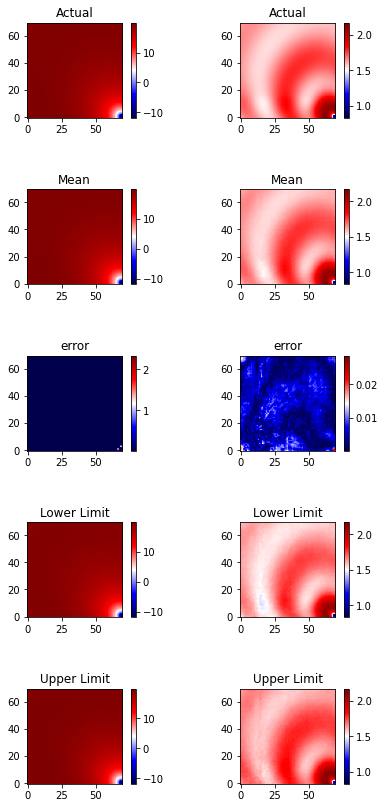

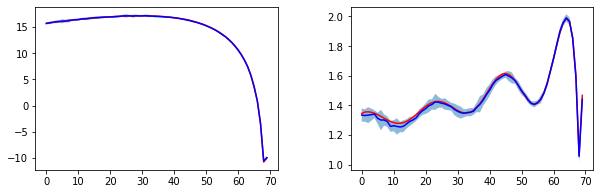

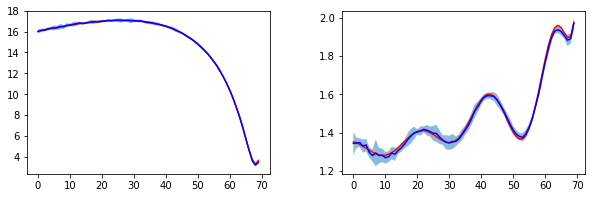

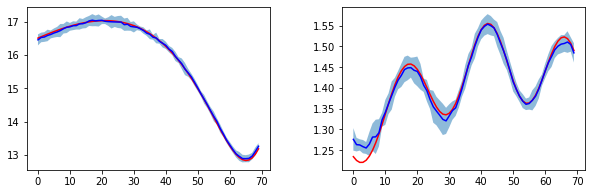

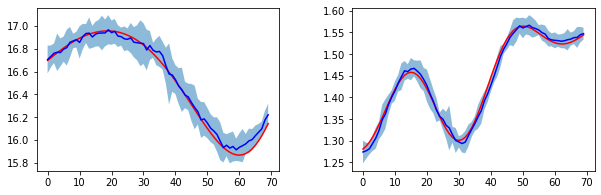

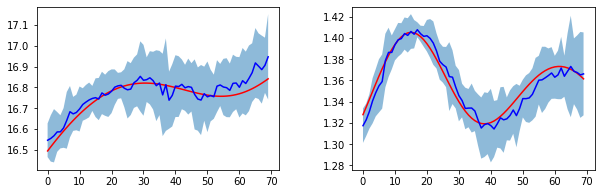

In [13]:
# %%

m = np.mean(pred.numpy(),0)
std = np.std(pred.numpy(),0)

plt.figure(constrained_layout=False, figsize = (7, 14))
plt.subplots_adjust(hspace=0.75)
index = 0

n = 20
for value in [n,n+4]:
        plt.subplot(5,2, index+1)
        plt.imshow(y_test[value,:,:], origin='lower', cmap='seismic',
                   vmin = np.min(y_test[value,:,:].numpy()), vmax = np.max(y_test[value,:,:].numpy()))
        plt.colorbar()
        plt.title('Actual')
                
        plt.subplot(5,2, index+1+2)
        plt.imshow(m[value,:,:], origin='lower', cmap='seismic',
                   vmin = np.min(y_test[value,:,:].numpy()), vmax = np.max(y_test[value,:,:].numpy()))
        plt.colorbar()
        plt.title('Mean')
                
        plt.subplot(5,2, index+1+4)
        plt.imshow(np.abs(y_test[value,:,:]-m[value,:,:])/np.abs(y_test[value,:,:]), origin='lower', cmap='seismic')
        plt.colorbar()
        plt.title('error')
                
        plt.subplot(5,2, index+1+6)
        plt.imshow(m[value,:,:]-1.96*std[value,:,:], origin='lower', cmap='seismic',
                   vmin = np.min(y_test[value,:,:].numpy()), vmax = np.max(y_test[value,:,:].numpy()))
        plt.colorbar()
        plt.title('Lower Limit')
        
        plt.subplot(5,2, index+1+8)
        plt.imshow(m[value,:,:]+1.96*std[value,:,:], origin='lower', cmap='seismic',
                   vmin = np.min(y_test[value,:,:].numpy()), vmax = np.max(y_test[value,:,:].numpy()))
        plt.colorbar()
        plt.title('Upper Limit')
                
        # plt.margins(0)
        index = index + 1
        
# # Relative loss norm(pred-test)/norm(test)
print((100*myloss(torch.tensor(m), y_test).item())/(ntest*5))
print(torch.mean((y_test-torch.tensor(m))**2).item()/torch.mean((y_test)**2).item())

# %%

for marker in ([1-1,5-1,15-1,30-1,50-1]):
    plt.figure(constrained_layout=False, figsize = (10, 3))
    plt.subplots_adjust(wspace=0.3)
    index = 0
    for value in [0,4]:
            plt.subplot(1,2, index+1)
            plt.plot(y_test[value,marker,:],'r')
            plt.plot(m[value,marker,:],'b')
            plt.fill_between(np.arange(0,70,1),m[value,marker,:]+1.96*std[value,marker,:],m[value,marker,:]-1.96*std[value,marker,:],alpha = 0.5)
            # plt.plot(m[value,marker,:]+1.96*std[value,marker,:],'m')
            # plt.plot(m[value,marker,:]-1.96*std[value,marker,:],'m')

            # plt.margins(0)
            index = index + 1
plt.show()


# %%

# torch.cuda.empty_cache()

# import scipy.io as sio
# sio.savemat('data_200.mat',{'pred':pred.numpy(), 'y_test':y_test.numpy()})


In [14]:
import scipy.io as sio

dataset1 = sio.loadmat('/DATA/SG/WNO/Randomized_prior/Reliability/Flat_vel_A/FVA_SX680SZ10FR30_2001_3000.mat')
print('hmm')
dataset2 = sio.loadmat('/DATA/SG/WNO/Randomized_prior/Reliability/Flat_vel_A/FVA_SX680SZ10FR30_3001_4000.mat')
print('hmm')
dataset3 = sio.loadmat('/DATA/SG/WNO/Randomized_prior/Reliability/Flat_vel_A/FVA_SX680SZ10FR30_4001_5000.mat')
print('hmm')
dataset4 = sio.loadmat('/DATA/SG/WNO/Randomized_prior/Reliability/Flat_vel_A/FVA_SX680SZ10FR30_5001_6000.mat')
print('hmm')
dataset5 = sio.loadmat('/DATA/SG/WNO/Randomized_prior/Reliability/Flat_vel_A/FVA_SX680SZ10FR30_6001_7000.mat')
print('hmm')

hmm
hmm
hmm
hmm
hmm


In [15]:
ntest = 5000
nfr = 5

fr0 = 1
fr1 = 3
fr2 = 5
fr3 = 7
fr4 = 9

in_vel = np.squeeze(dataset1['vel_final'])
out_fr0 = dataset1['fft_final_im'][:,fr0]
out_fr1 = dataset1['fft_final_im'][:,fr1]
out_fr2 = dataset1['fft_final_im'][:,fr2]
out_fr3 = dataset1['fft_final_im'][:,fr3]
out_fr4 = dataset1['fft_final_im'][:,fr4]
print('hmm')

in_vel = np.concatenate([in_vel, np.squeeze(dataset2['vel_final'])], axis = 0)
out_fr0 = np.concatenate([out_fr0, dataset2['fft_final_im'][:,fr0]], axis = 0)
out_fr1 = np.concatenate([out_fr1, dataset2['fft_final_im'][:,fr1]], axis = 0)
out_fr2 = np.concatenate([out_fr2, dataset2['fft_final_im'][:,fr2]], axis = 0)
out_fr3 = np.concatenate([out_fr3, dataset2['fft_final_im'][:,fr3]], axis = 0)
out_fr4 = np.concatenate([out_fr4, dataset2['fft_final_im'][:,fr4]], axis = 0)
print('hmm')

in_vel = np.concatenate([in_vel, np.squeeze(dataset3['vel_final'])], axis = 0)
out_fr0 = np.concatenate([out_fr0, dataset3['fft_final_im'][:,fr0]], axis = 0)
out_fr1 = np.concatenate([out_fr1, dataset3['fft_final_im'][:,fr1]], axis = 0)
out_fr2 = np.concatenate([out_fr2, dataset3['fft_final_im'][:,fr2]], axis = 0)
out_fr3 = np.concatenate([out_fr3, dataset3['fft_final_im'][:,fr3]], axis = 0)
out_fr4 = np.concatenate([out_fr4, dataset3['fft_final_im'][:,fr4]], axis = 0)
print('hmm')

in_vel = np.concatenate([in_vel, np.squeeze(dataset4['vel_final'])], axis = 0)
out_fr0 = np.concatenate([out_fr0, dataset4['fft_final_im'][:,fr0]], axis = 0)
out_fr1 = np.concatenate([out_fr1, dataset4['fft_final_im'][:,fr1]], axis = 0)
out_fr2 = np.concatenate([out_fr2, dataset4['fft_final_im'][:,fr2]], axis = 0)
out_fr3 = np.concatenate([out_fr3, dataset4['fft_final_im'][:,fr3]], axis = 0)
out_fr4 = np.concatenate([out_fr4, dataset4['fft_final_im'][:,fr4]], axis = 0)
print('hmm')

in_vel = np.concatenate([in_vel, np.squeeze(dataset5['vel_final'])], axis = 0)
out_fr0 = np.concatenate([out_fr0, dataset5['fft_final_im'][:,fr0]], axis = 0)
out_fr1 = np.concatenate([out_fr1, dataset5['fft_final_im'][:,fr1]], axis = 0)
out_fr2 = np.concatenate([out_fr2, dataset5['fft_final_im'][:,fr2]], axis = 0)
out_fr3 = np.concatenate([out_fr3, dataset5['fft_final_im'][:,fr3]], axis = 0)
out_fr4 = np.concatenate([out_fr4, dataset5['fft_final_im'][:,fr4]], axis = 0)
print('hmm')

# from sklearn.utils import shuffle

# in_vel, out_fr0, out_fr1, out_fr2, out_fr3, out_fr4 = shuffle(in_vel,
#                                                               out_fr0,
#                                                               out_fr1,
#                                                               out_fr2,
#                                                               out_fr3,
#                                                               out_fr4, random_state = 0)

x_test = torch.zeros([ntest*nfr,s,s,2])
y_test = torch.zeros([ntest*nfr,s,s])
for i in range(ntest):
    if i%500 == 0:
        print(i)
    for j in range(nfr):
        x_test[i*nfr+j,:,:,0] = torch.tensor(in_vel[-i,:,:].astype(np.float64), dtype=torch.float)
        
        if j == 0:
            x_test[i*nfr+j,:,:,1] = torch.zeros([70,70], dtype=torch.float)+fr0
            y_test[i*nfr+j,:,:] = torch.tensor(out_fr0[-i,:,:].astype(np.float64), dtype=torch.float)
        elif j == 1:
            x_test[i*nfr+j,:,:,1] = torch.zeros([70,70], dtype=torch.float)+fr1
            y_test[i*nfr+j,:,:] = torch.tensor(out_fr1[-i,:,:].astype(np.float64), dtype=torch.float)
        elif j == 2:
            x_test[i*nfr+j,:,:,1] = torch.zeros([70,70], dtype=torch.float)+fr2
            y_test[i*nfr+j,:,:] = torch.tensor(out_fr2[-i,:,:].astype(np.float64), dtype=torch.float)
        elif j == 3:
            x_test[i*nfr+j,:,:,1] = torch.zeros([70,70], dtype=torch.float)+fr3
            y_test[i*nfr+j,:,:] = torch.tensor(out_fr3[-i,:,:].astype(np.float64), dtype=torch.float)
        elif j == 4:
            x_test[i*nfr+j,:,:,1] = torch.zeros([70,70], dtype=torch.float)+fr4
            y_test[i*nfr+j,:,:] = torch.tensor(out_fr4[-i,:,:].astype(np.float64), dtype=torch.float)

hmm
hmm
hmm
hmm
hmm
0
500
1000
1500
2000
2500
3000
3500
4000
4500


In [16]:
x_test.shape, y_test.shape

(torch.Size([25000, 70, 70, 2]), torch.Size([25000, 70, 70]))

In [17]:
filename = './dataset_ytr_im.sav'
y_train = pickle.load(open(filename, 'rb'))


y_normalizer = UnitGaussianNormalizer(y_train)
x_test = x_normalizer.encode(x_test)
y_train = y_normalizer.encode(y_train)

# test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test),
#                                           batch_size=batch_size, shuffle=False)

In [18]:
y_normalizer.cuda_device(device)

In [19]:
s = h

""" Prediction """

pred = torch.zeros([10, y_test.shape[0], y_test.shape[1], y_test.shape[2]])
myloss = LpLoss(size_average=False)

batch_size = 250
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

for model_num in range (0,10):

    print(model_num)
    
    filename = './RPmodel/CWT_TR1_model_im_nt_freq_1_3_5_7_9_'+str(model_num)+'.sav'
    model_NT = pickle.load(open(filename, 'rb')).to(device)
    
    NT_pred_test = torch.zeros(y_test.shape).cpu()
    for i in range(x_test.shape[0]//batch_size):
        NT_pred_test[i*batch_size:(i+1)*batch_size] = model_NT(x_test[i*batch_size:(i+1)*batch_size].to(device)).reshape(batch_size, s, s).cpu()

    
    filename = './RPmodel/CWT_TR1_model_im_t_freq_1_3_5_7_9_'+str(model_num)+'.sav'
    loaded_model = pickle.load(open(filename, 'rb')).to(device)

    index = 0
    test_e = torch.zeros(y_test.shape[0])
    with torch.no_grad():
        i = 0
        for x, y in test_loader:
            test_l2 = 0
            x, y = x.to(device), y.to(device)
    
            out = loaded_model(x).reshape(batch_size, s, s)+NT_pred_test[i*batch_size:(i+1)*batch_size].to(device)
            out = y_normalizer.decode(out)
            pred[model_num,index*batch_size:(index+1)*batch_size,:,:] = out
    
            test_l2 = myloss(out.reshape(batch_size, s, s), y.reshape(batch_size, s, s)).item()
            test_e[index] = test_l2
            
            print(model_num, index, test_l2)
            index = index + 1
            i = i+1
            
        print('Mean Testing Error:', 100*torch.mean(test_e).numpy(), '%')

0
0 0 2.4965689182281494
0 1 2.475224494934082
0 2 2.569145679473877
0 3 2.42258882522583
0 4 2.657681941986084
0 5 2.836073398590088
0 6 2.4176478385925293
0 7 2.545402765274048
0 8 2.795349597930908
0 9 2.4869472980499268
0 10 2.7319836616516113
0 11 2.5502872467041016
0 12 2.578068971633911
0 13 2.3041796684265137
0 14 2.494229555130005
0 15 2.6188440322875977
0 16 2.7044968605041504
0 17 2.6129465103149414
0 18 2.5950818061828613
0 19 2.4668664932250977
0 20 2.520901679992676
0 21 2.6934452056884766
0 22 2.429415702819824
0 23 2.499833345413208
0 24 2.2098288536071777
0 25 2.6093101501464844
0 26 2.5101990699768066
0 27 2.3739736080169678
0 28 2.7511205673217773
0 29 2.6957993507385254
0 30 2.5419745445251465
0 31 2.2389378547668457
0 32 2.501600980758667
0 33 2.5819687843322754
0 34 2.396820068359375
0 35 2.826101303100586
0 36 2.8469138145446777
0 37 2.8002424240112305
0 38 2.593355655670166
0 39 2.6626570224761963
0 40 2.455630302429199
0 41 2.8051986694335938
0 42 2.39393615722

0.32658314098011365
0.0027604663662240303


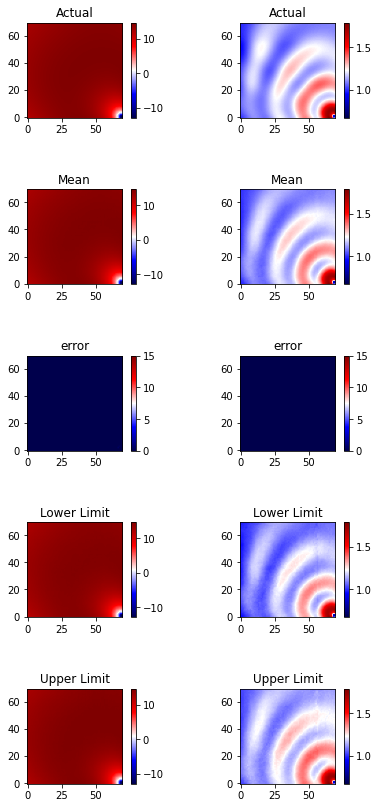

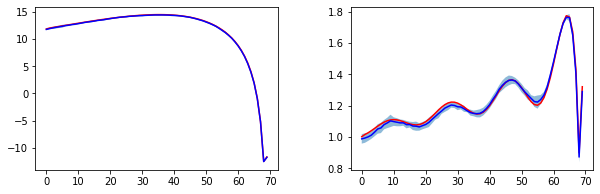

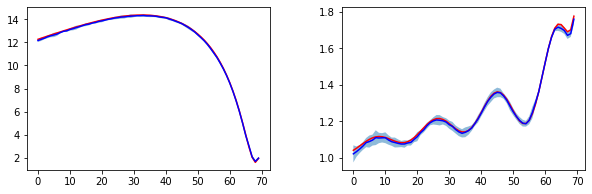

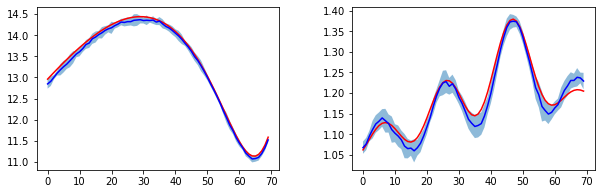

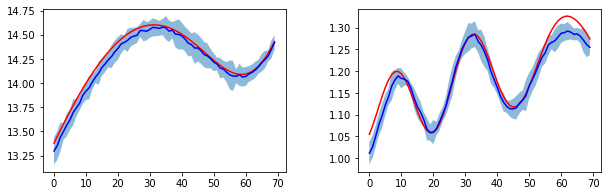

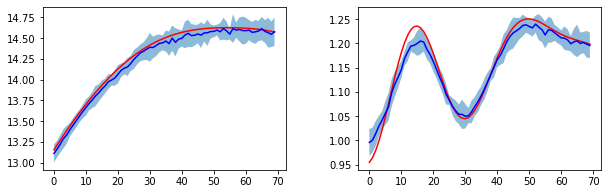

In [25]:
# %%

m = np.mean(pred.numpy(),0)
std = np.std(pred.numpy(),0)

plt.figure(constrained_layout=False, figsize = (7, 14))
plt.subplots_adjust(hspace=0.75)
index = 0
n = 2000

for value in [n,n+4]:
        plt.subplot(5,2, index+1)
        plt.imshow(y_test[value,:,:], origin='lower', cmap='seismic',
                   vmin = np.min(y_test[value,:,:].numpy()), vmax = np.max(y_test[value,:,:].numpy()))
        plt.colorbar()
        plt.title('Actual')
                
        plt.subplot(5,2, index+1+2)
        plt.imshow(m[value,:,:], origin='lower', cmap='seismic',
                   vmin = np.min(y_test[value,:,:].numpy()), vmax = np.max(y_test[value,:,:].numpy()))
        plt.colorbar()
        plt.title('Mean')
                
        plt.subplot(5,2, index+1+4)
        plt.imshow(np.abs(y_test[value,:,:]-m[value,:,:])/np.abs(y_test[value,:,:]), origin='lower', cmap='seismic',
                  vmin = 0, vmax = 15)
        plt.colorbar()
        plt.title('error')
                
        plt.subplot(5,2, index+1+6)
        plt.imshow(m[value,:,:]-1.96*std[value,:,:], origin='lower', cmap='seismic',
                   vmin = np.min(y_test[value,:,:].numpy()), vmax = np.max(y_test[value,:,:].numpy()))
        plt.colorbar()
        plt.title('Lower Limit')
        
        plt.subplot(5,2, index+1+8)
        plt.imshow(m[value,:,:]+1.96*std[value,:,:], origin='lower', cmap='seismic',
                   vmin = np.min(y_test[value,:,:].numpy()), vmax = np.max(y_test[value,:,:].numpy()))
        plt.colorbar()
        plt.title('Upper Limit')
                
        # plt.margins(0)
        index = index + 1
        
# # Relative loss norm(pred-test)/norm(test)
print((100*myloss(torch.tensor(m), y_test).item())/(ntest*11))
print(100*torch.mean((y_test-torch.tensor(m))**2).item()/torch.mean((y_test)**2).item())

# %%

for marker in ([1-1,5-1,15-1,30-1,50-1]):
    plt.figure(constrained_layout=False, figsize = (10, 3))
    plt.subplots_adjust(wspace=0.3)
    index = 0
    for value in [n,n+4]:
            plt.subplot(1,2, index+1)
            plt.plot(y_test[value,marker,:],'r')
            plt.plot(m[value,marker,:],'b')
            plt.fill_between(np.arange(0,70,1),m[value,marker,:]+1.96*std[value,marker,:],m[value,marker,:]-1.96*std[value,marker,:],alpha = 0.5)
            # plt.plot(m[value,marker,:]+1.96*std[value,marker,:],'m')
            # plt.plot(m[value,marker,:]-1.96*std[value,marker,:],'m')

            # plt.margins(0)
            index = index + 1
plt.show()


# %%

# torch.cuda.empty_cache()

# import scipy.io as sio
# sio.savemat('data_200.mat',{'pred':pred.numpy(), 'y_test':y_test.numpy()})


In [24]:
import scipy.io as sio
sio.savemat('./pred/im_CWT_TR1_new_data_RPpredmat_seismic_1fr.mat',mdict={'pred': pred[:,0:25000:5,:,:].cpu().numpy(), 'ytest': y_test[0:25000:5,:,:].cpu().numpy()})
sio.savemat('./pred/im_CWT_TR1_new_data_RPpredmat_seismic_3fr.mat',mdict={'pred': pred[:,1:25000:5,:,:].cpu().numpy(), 'ytest': y_test[1:25000:5,:,:].cpu().numpy()})
sio.savemat('./pred/im_CWT_TR1_new_data_RPpredmat_seismic_5fr.mat',mdict={'pred': pred[:,2:25000:5,:,:].cpu().numpy(), 'ytest': y_test[2:25000:5,:,:].cpu().numpy()})
sio.savemat('./pred/im_CWT_TR1_new_data_RPpredmat_seismic_7fr.mat',mdict={'pred': pred[:,3:25000:5,:,:].cpu().numpy(), 'ytest': y_test[3:25000:5,:,:].cpu().numpy()})
sio.savemat('./pred/im_CWT_TR1_new_data_RPpredmat_seismic_9fr.mat',mdict={'pred': pred[:,4:25000:5,:,:].cpu().numpy(), 'ytest': y_test[4:25000:5,:,:].cpu().numpy()})